<a href="https://colab.research.google.com/github/Mafaz03/Model/blob/main/ResNet_Max.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Setting up basic required Libraries

## 1.1 Importing Torch and setting the Appropriate Device

In [1]:
import torch
from torch import nn

In [2]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
print(f"Device : {device}")

Device : cuda


# 2 Getting the Dataset and Visualization

Source : https://github.com/Mafaz03/Datasets/tree/main/Pets_dataset

The Dataset has been divided into Train and Test set to avoid any issues that may have been caused due to Github maximum file uploading size (ie if the zip file contained Train and Test Dataset together)

In [3]:
from pathlib import Path
import requests
import zipfile

data_path = Path("Pet_Data/")


if data_path.is_dir():
  print("Directory already exits")

else:
  print("Creating Directory...........")
  data_path.mkdir(parents=True, exist_ok=True)

  with open(data_path / "Train.zip" , "wb") as f:
    request_train = requests.get("https://github.com/Mafaz03/Datasets/raw/main/Pets_dataset/Train.zip")
    print("Downloading Train Dataset.................")
    f.write(request_train.content)
  
  with open(data_path / "Test.zip" , "wb") as t:
    request_test = requests.get("https://github.com/Mafaz03/Datasets/raw/main/Pets_dataset/Test.zip")
    print("Downloading Test Dataset.................")
    t.write(request_test.content)

  with zipfile.ZipFile(data_path / "Train.zip") as zip_ref_train:
    print("Unzipping Train Dataset.................")
    zip_ref_train.extractall(data_path)

  with zipfile.ZipFile(data_path / "Test.zip") as zip_ref_test:
    print("Unzipping Train Dataset.................")
    zip_ref_test.extractall(data_path)



Creating Directory...........
Unzipping Train Dataset.................
Unzipping Train Dataset.................


In [4]:
train_path = data_path / "Train"
test_path = data_path / "Test"

train_path , test_path

(PosixPath('Pet_Data/Train'), PosixPath('Pet_Data/Test'))

## 2.1 Visualizing file structure 

Helps with checking if the heirarchy is in right order for the respected loaders

In [5]:
try:
  from treelib import Node, Tree
  print("treelib is already isntalled\nImporting treelib packae")
except:
  print("Installing and importing treelib package")
  !pip install treelib
  from treelib import Node, Tree



Installing and importing treelib package
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import os

def file_structure(directory):
  for dirpath, dirnames, filenames in os.walk(directory):
    #print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    return dirnames , len(filenames) , dirpath

In [7]:
def file_tree(root : str ,
              Train_path : str ,
              Test_path : str):

  tree = Tree()

  i = Train_path
  j = Test_path

  g = file_structure(data_path)



  train_node = str(g[0][1])
  test_node = str(g[0][0])

  tree.create_node(root.upper(), root.lower())

  #Root node is devided into : Train | Test

  tree.create_node(train_node.upper(), train_node.lower(), parent=root.lower())
  tree.create_node(test_node.upper(), test_node.lower(), parent=root.lower())

  for classes in range(len(j[0])):

    _ , len_train , _  = file_structure(data_path / "Train" / i[0][classes].lower())
    _ , len_test, _  = file_structure(data_path / "Test" / i[0][classes].lower())

    tree.create_node(i[0][classes].split(".")[0].lower() +  " (" + str(len_train - 1 ) + " image)", i[0][classes].split(".")[0].lower(), parent=train_node.lower())
    tree.create_node(j[0][classes].split(".")[0].lower() + " (" + str(len_test - 1) + " image)", j[0][classes], parent=test_node.lower())

    

  tree.show(line_type="ascii-em")

In [8]:
file_tree(root = "Pet_Data" ,
          Train_path = file_structure(data_path/"Train") ,
          Test_path = file_structure(data_path/"Test"))

PET_DATA
╠══ TEST
║   ╠══ beagle (20 image)
║   ╠══ boxer (19 image)
║   ╠══ husky (19 image)
║   ╠══ mumbai cat (20 image)
║   ╠══ persian cat (20 image)
║   ╚══ ragdoll cat (20 image)
╚══ __MACOSX
    ╠══ beagle (80 image)
    ╠══ boxer (80 image)
    ╠══ husky (80 image)
    ╠══ mumbai cat (80 image)
    ╠══ persian cat (80 image)
    ╚══ ragdoll cat (80 image)



## 2.2 Visualizing random images

Randomly selecting images from Train and Test path and displaying it in a grid using matplotlib

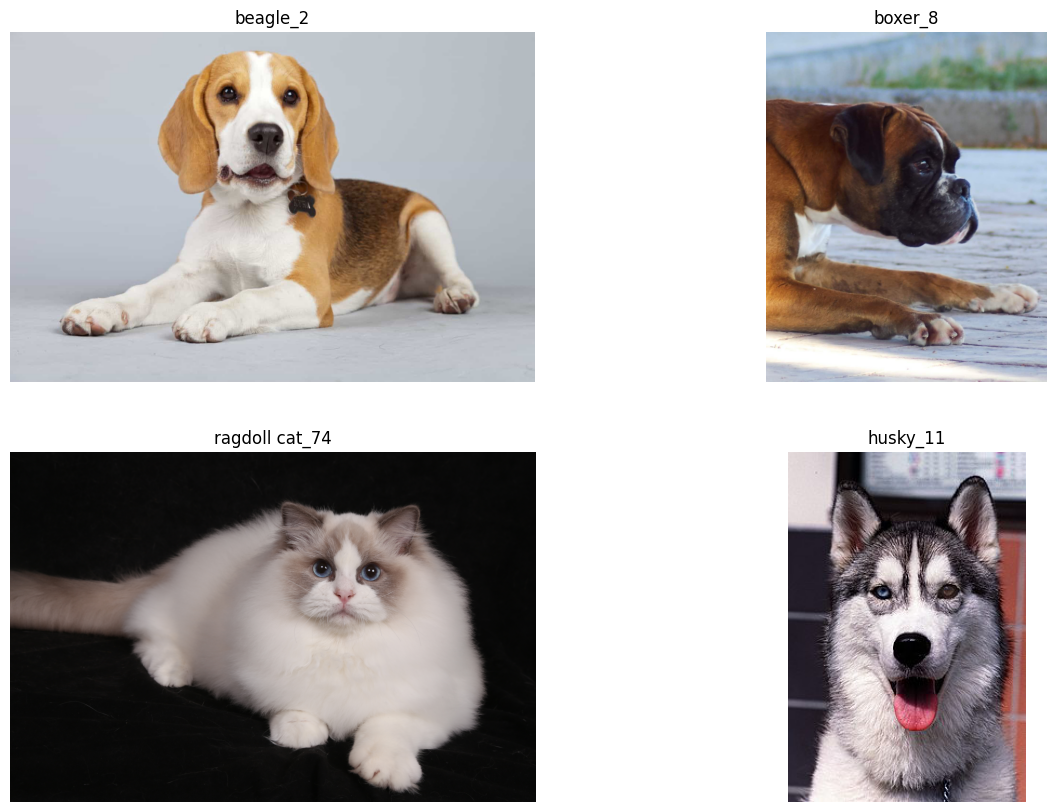

In [9]:
import random
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 10))

for random_image_choice in range(4):

  plt.subplot(2 , 2 , random_image_choice + 1)
  random_image_path = random.choice(list(data_path.glob("*/*/*.jpg")))
  random_image = plt.imread(random_image_path)
  plt.title(random_image_path.stem)
  plt.imshow(random_image)
  plt.axis("off")


# 3 Preparing Data

-> Creating Transform (TrivialAugmentWide)

-> Loading image data (using ImageFolder from torchvision)

-> Creating Dataoader (So that itteration in the train and test dataset is possible)

## 3.1 Creating Transforms

In [10]:
from torchvision import transforms 

train_transform_trivial = transforms.Compose([
    transforms.Resize((224 ,224)) ,
    transforms.TrivialAugmentWide(num_magnitude_bins = 31) ,
    transforms.ToTensor()
])

test_transform_trivial = transforms.Compose([
    transforms.Resize((224 ,224)) ,
    transforms.ToTensor()
])

train_transform_trivial , test_transform_trivial

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
     ToTensor()
 ))

In [11]:
data_transform_trivial = transforms.Compose([
    transforms.Resize((64 ,64)) ,
    transforms.TrivialAugmentWide(num_magnitude_bins = 31) ,
    transforms.ToTensor()
])

data_transform_trivial

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ToTensor()
)

### 3.1.1 Visiualizing Transfom

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision

def plot_transform(image_path : str , 
                   transform : torchvision.transforms):

  plt.figure(figsize = (10 , 10))

  image_path = random.choice(list(data_path.glob("*/*/*.jpg")))

  image_test = plt.imread(image_path)
  plt.subplot(2 , 2 , 1)
  plt.title(f"{image_path.stem} | Shape : {image_test.shape}")
  plt.axis("off")
  plt.imshow(image_test)


  with Image.open(image_path) as PIL_test_image:
    transformed_image = data_transform_trivial(PIL_test_image).permute(1 , 2 , 0)
    plt.subplot(2 , 2 , 2)
    plt.axis("off")
    plt.title(f"{image_path.stem} | Shape : {transformed_image.shape}")
    plt.imshow(transformed_image)
    print(transformed_image.shape)


torch.Size([64, 64, 3])


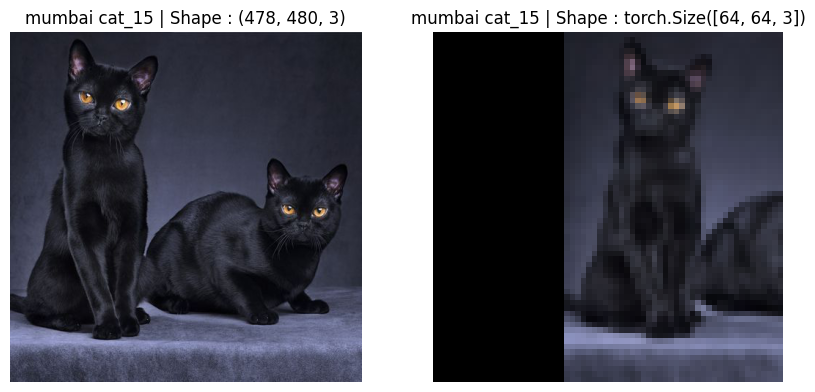

In [13]:
import random
random_image_path = random.choice(list(data_path.glob("*/*/*.jpg")))

plot_transform(image_path = random_image_path , 
               transform = data_transform_trivial)

## 3.2 Loading Data using ImageFolder

In [14]:
from torchvision import datasets

train_data_trivial = datasets.ImageFolder(root = train_path ,
                                           transform = data_transform_trivial ,
                                           target_transform = None)

test_data_trivial = datasets.ImageFolder(root = test_path ,
                                           transform = data_transform_trivial )

train_data_trivial , test_data_trivial

(Dataset ImageFolder
     Number of datapoints: 480
     Root location: Pet_Data/Train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 120
     Root location: Pet_Data/Test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ))

In [15]:
class_names = train_data_trivial.classes
class_dict = train_data_trivial.class_to_idx

print(f"Class names : {class_names} \nclass dictionary : {class_dict}")

Class names : ['beagle.dog', 'boxer.dog', 'husky.dog', 'mumbai cat.cat', 'persian cat.cat', 'ragdoll cat.cat'] 
class dictionary : {'beagle.dog': 0, 'boxer.dog': 1, 'husky.dog': 2, 'mumbai cat.cat': 3, 'persian cat.cat': 4, 'ragdoll cat.cat': 5}


In [16]:
print(f"data type of image after laoding : {(type(train_data_trivial[0][0]))} |\nLabel Datatype after loading :  {type(train_data_trivial[0][1])}")

data type of image after laoding : <class 'torch.Tensor'> |
Label Datatype after loading :  <class 'int'>


## 3.3 Creating DataLoader

In [17]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 32

train_dataloader_trivial = DataLoader(dataset = train_data_trivial , 
                                      num_workers = os.cpu_count() , 
                                      batch_size = BATCH_SIZE,
                                      shuffle = True)

test_dataloader_trivial = DataLoader(dataset = test_data_trivial , 
                                      num_workers = os.cpu_count() , 
                                      batch_size = BATCH_SIZE,
                                      shuffle = False)

train_dataloader_trivial , test_dataloader_trivial


(<torch.utils.data.dataloader.DataLoader at 0x7fa6b00b5220>,
 <torch.utils.data.dataloader.DataLoader at 0x7fa6b00b5280>)

In [18]:
img , label = next(iter(train_dataloader_trivial))

print(f"Image shape : {img.shape}")
print(f"Label shape : {label.shape}")

Image shape : torch.Size([32, 3, 64, 64])
Label shape : torch.Size([32])


# 4 Creating Model Class

In [19]:
#ResNet Model
#This resnet model has 12 layers confined in 2 blocks
#Uses MaxPool on the recursive layer to maintain the correct shape for futhur be added


class ResNet2_Max(nn.Module):

  def __init__(self , input_shape : int , hidden_units : int , output_shape : int ) -> None :

    super().__init__()


    self.MaxPool_layer = nn.MaxPool2d(2)


    self.conv_block_1 = nn.Sequential(
        
        nn.Conv2d(in_channels = input_shape , out_channels = hidden_units , kernel_size = 3 ,stride = 1 , padding = 1),

        nn.BatchNorm2d(3),

        nn.ReLU(),

        nn.Conv2d(in_channels = hidden_units , out_channels = hidden_units , kernel_size = 3 ,stride = 1 , padding = 1),
        
        nn.BatchNorm2d(3),

        nn.MaxPool2d(2)

        )
    

    self.conv_block_2 = nn.Sequential(
        
        nn.Conv2d(in_channels = hidden_units , out_channels = hidden_units , kernel_size = 3 ,stride = 1 , padding = 1),

        nn.BatchNorm2d(3),

        nn.ReLU(),

        nn.Conv2d(in_channels = hidden_units , out_channels = hidden_units , kernel_size = 3 ,stride = 1 , padding = 1),
        
        nn.BatchNorm2d(3),

        nn.MaxPool2d(2)

        )
                     

    self.classifier = nn.Sequential(
        
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*32*32 ,
                  out_features=output_shape)
        )
    
  def forward(self , x : torch.Tensor):

    identity_1 = x
    #print("Identify Shape : ",identity_1.shape)

    identity_2 = self.MaxPool_layer(identity_1)
    #print("Identify_1 Shape : ",identity_2.shape)
    
    out_1 = self.conv_block_1(x)
    #print(out_1.shape)

    out_2 = self.conv_block_2(out_1)
    #print(out_2.shape)

    out = out_1 + identity_2
    #print("out shape : ",out.shape)

    identity_3 = self.MaxPool_layer(identity_2)
    #print("Identify_1 Shape : ",identity_3.shape)

    out = out_1 + identity_2
    #print("out shape : ",out.shape)

    return self.classifier(out)

In [20]:
ResNet2_Max_model = ResNet2_Max(input_shape = 3 , hidden_units=3 , output_shape=len(train_data_trivial.classes)).to(device)
ResNet2_Max_model

ResNet2_Max(
  (MaxPool_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block_1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

In [21]:
image_test , label_test = next(iter(train_dataloader_trivial))
single_image , single_label = image_test[0].unsqueeze(dim = 0).to(device) , label_test[0].to(device)

print(f"Single image shape: {single_image.shape}\n")

ResNet2_Max_model.eval()
with torch.inference_mode():
  pred = ResNet2_Max_model(single_image.to(device))

print(f"Output Logits : {pred}")
prediction = torch.argmax(torch.softmax(pred , dim = 1) , dim = 1)
print(f"Prediction : {class_names[prediction]}")
print(f"Actual Label {class_names[single_label]}")

Single image shape: torch.Size([1, 3, 64, 64])

Output Logits : tensor([[ 0.2133, -0.1625,  0.1404, -0.5324, -0.1980, -0.4666]],
       device='cuda:0')
Prediction : beagle.dog
Actual Label beagle.dog


## 4.1 Visiualizing the Model

In [22]:
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(ResNet2_Max_model, input_size=[1, 3, 64, 64])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
ResNet2_Max                              [1, 6]                    --
├─MaxPool2d: 1-1                         [1, 3, 32, 32]            --
├─Sequential: 1-2                        [1, 3, 32, 32]            --
│    └─Conv2d: 2-1                       [1, 3, 64, 64]            84
│    └─BatchNorm2d: 2-2                  [1, 3, 64, 64]            6
│    └─ReLU: 2-3                         [1, 3, 64, 64]            --
│    └─Conv2d: 2-4                       [1, 3, 64, 64]            84
│    └─BatchNorm2d: 2-5                  [1, 3, 64, 64]            6
│    └─MaxPool2d: 2-6                    [1, 3, 32, 32]            --
├─Sequential: 1-3                        [1, 3, 16, 16]            --
│    └─Conv2d: 2-7                       [1, 3, 32, 32]            84
│    └─BatchNorm2d: 2-8                  [1, 3, 32, 32]            6
│    └─ReLU: 2-9                         [1, 3, 32, 32]            --
│    └─Conv2d: 2-1

# 5 Creating Train step , Test step

## 5.1 Train Step

In [23]:
def train_step(model : torch.nn.Module ,
               loss_fn : torch.nn.Module ,
               dataloader : torch.utils.data.DataLoader ,
               optimizer : torch.optim.Optimizer) :
               
  model.train()
  
  train_loss , train_acc = 0 , 0

  for batch , (X , y) in enumerate(dataloader):

    X , y = X.to(device) , y.to(device)

    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    train_prediction = torch.argmax(torch.softmax(y_pred , dim = 1), dim = 1)

    train_acc += (train_prediction == y).sum().item() / len(y_pred)

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss , train_acc

## 5.3 Test Step

In [24]:
def test_step(model : torch.nn.Module , 
              loss_fn : torch.nn.Module ,
               dataloader : torch.utils.data.DataLoader ):

  model.eval()

  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

## 5.4 Integrating Train step and Test step in one function

In [25]:
from tqdm.auto import tqdm


def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  results = {"train_loss" : [], "train_acc" : [] , "test_loss" : [] , "test_acc" : []}

  for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_step(model=model , dataloader=train_dataloader , loss_fn=loss_fn , optimizer=optimizer)
    
    test_loss, test_acc = test_step(model=model,dataloader=test_dataloader_trivial,loss_fn=loss_fn)

    train_acc , test_acc = train_acc*100 , test_acc*100
                                           
                                           
    
    print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} % | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f} %")

   
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results



## 5.5 Training

In [26]:
from timeit import default_timer as timer

model_path = Path("/content/Models/")
model_name = Path("ResNet2_Max_0")

if os.path.isfile(model_path/model_name):
  print("Model Already Exist....\nLoading.......")
  ResNet2_Max_model = torch.load("/content/Models/ResNet2_Max_0")

else:

  ResNet2_Max_model = ResNet2_Max(input_shape = 3 , hidden_units = 3 , output_shape = len(train_data_trivial)).to(device)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(params=ResNet2_Max_model.parameters(), lr=0.001)

  NUM_EPOCHS = 20

  start_timer = timer()

  ResNet2_results = train(model = ResNet2_Max_model , train_dataloader = train_dataloader_trivial , test_dataloader = test_dataloader_trivial , loss_fn = loss_fn , optimizer = optimizer , epochs=NUM_EPOCHS)

  end_timer = timer()

  print(f"Time Taken : {end_timer-start_timer:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1814 | train_acc: 24.5833 % | test_loss: 1.8768 | test_acc: 19.0104 %
Epoch: 2 | train_loss: 1.6190 | train_acc: 41.2500 % | test_loss: 1.6949 | test_acc: 27.6042 %
Epoch: 3 | train_loss: 1.5255 | train_acc: 41.6667 % | test_loss: 1.8925 | test_acc: 26.0417 %
Epoch: 4 | train_loss: 1.5145 | train_acc: 44.7917 % | test_loss: 1.9011 | test_acc: 38.8021 %
Epoch: 5 | train_loss: 1.4101 | train_acc: 50.6250 % | test_loss: 1.7228 | test_acc: 32.2917 %
Epoch: 6 | train_loss: 1.2819 | train_acc: 52.5000 % | test_loss: 1.8228 | test_acc: 27.3438 %
Epoch: 7 | train_loss: 1.3669 | train_acc: 50.0000 % | test_loss: 1.7846 | test_acc: 31.2500 %
Epoch: 8 | train_loss: 1.2228 | train_acc: 58.3333 % | test_loss: 1.8534 | test_acc: 26.8229 %
Epoch: 9 | train_loss: 1.2457 | train_acc: 56.8750 % | test_loss: 1.6905 | test_acc: 34.1146 %
Epoch: 10 | train_loss: 1.1474 | train_acc: 61.0417 % | test_loss: 1.9397 | test_acc: 29.4271 %
Epoch: 11 | train_loss: 1.2089 | train_acc: 55.83

# 6 Plotting Curves

In [27]:
def curve_plot(results : dict[str , list[float]] , ranges ,size = (15,7)):


  train_loss = results['train_loss']
  train_acc = results['train_acc']
  test_loss = results['test_loss']
  test_acc = results['test_acc']

  epoch = range(ranges)
  plt.figure(figsize = size)
  plt.subplot(1 , 2 , 1)
  plt.plot(epoch , train_loss , label = 'train loss')
  plt.plot(epoch , test_loss ,label = 'test loss')
  plt.legend()
  plt.title("Train loss vs Test loss")
  plt.xlabel("epochs")
  plt.ylabel("losses")

  plt.subplot(1 , 2 ,2)
  plt.plot(epoch , train_acc , label = 'train acc')
  plt.plot(epoch , test_acc ,label = 'test acc')
  plt.legend()
  plt.title("Train acc vs Test acc")
  plt.xlabel("epochs")
  plt.ylabel("Accuracy")
  plt.show()

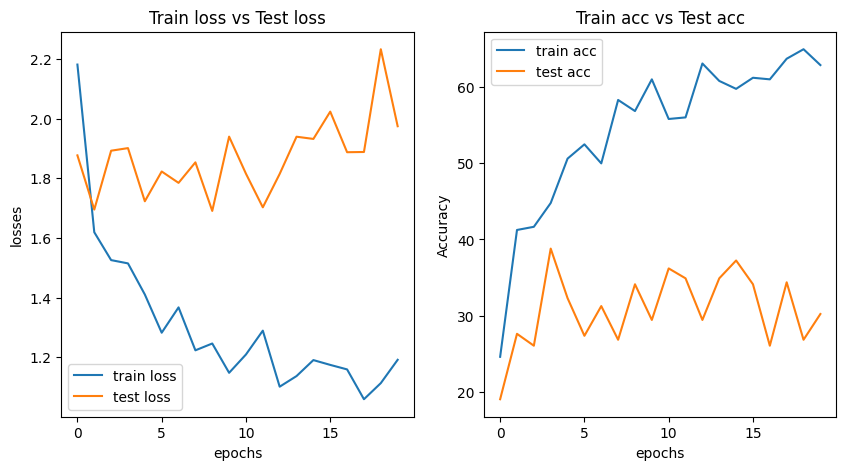

In [28]:
if os.path.isfile(model_path/model_name):
  print("Loaded model doesnt contain results dictionary to plot the graph\n")

else:  
  curve_plot(ResNet2_results , ranges = 20, size = (10 , 5))

# 7 Save and Reload

In [29]:
from pathlib import Path

if os.path.isfile(model_path/model_name):
  print("Model Already exists")

else:

  save_model_path = Path("Models")

  if save_model_path.is_dir():
    print("Directory already exits")

  else:
    print("Creating Directory...........")
    save_model_path.mkdir(parents=True, exist_ok=True)

  torch.save(ResNet2_Max_model , save_model_path / "TinyVGG_0")

Creating Directory...........


#8 Making Prediction

## 8.1 Making prediction on single image

In [30]:
random_test_image = random.choice(list(test_path.glob("*/*.jpg")))
random_test_image

PosixPath('Pet_Data/Test/ragdoll cat.cat/ragdoll cat_100.jpg')

reading the image path
torch.Size([450, 450, 3])

Brining range of image pixels [0 - 1]
torch.Size([450, 450, 3])

h w c -> c h w
torch.Size([3, 450, 450])

Resizing to 64x64
torch.Size([3, 64, 64])

Adding Batch Size of 1
torch.Size([1, 3, 64, 64])



/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(-0.5, 63.5, 63.5, -0.5)

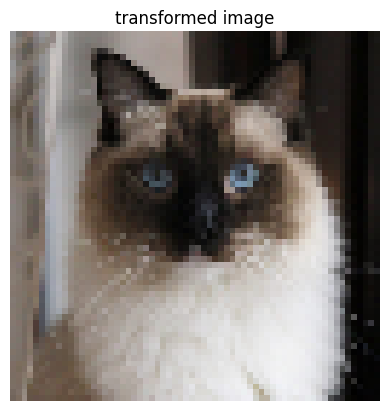

In [31]:
from PIL import Image
import torch

#reading the image path
f = plt.imread(random_test_image)
f = torch.from_numpy(f)
print("reading the image path")
print(f"{f.shape}\n")

#Brining range of image pixels [0 - 1]
f = f/255
print("Brining range of image pixels [0 - 1]")
print(f"{f.shape}\n")

#h w c -> c h w
f = f.permute(2 , 0 , 1)
print("h w c -> c h w")
print(f"{f.shape}\n")

test_transform = transforms.Compose([
    transforms.Resize((64,64))
])

#Resizing to 64x64
f_transformed = test_transform(f)
print("Resizing to 64x64")
print(f"{f_transformed.shape}\n")

#Adding Batch Size of 1
f_transformed_batch = f_transformed.unsqueeze(dim=0)
print("Adding Batch Size of 1")
print(f"{f_transformed_batch.shape}\n")

plt.imshow(f_transformed.permute(1 , 2 , 0))
plt.title("transformed image")
plt.axis("off")

## 8.1.1 functionalizing the image preperation

In [32]:
def preparation(ran_image_path):

  test_transform = transforms.Compose([
    transforms.Resize((64,64))
  ])

  image_tensor = torch.from_numpy(plt.imread(ran_image_path))/255
  image_permute = image_tensor.permute(2 , 0 , 1)
  image_transformed = test_transform(image_permute)
  image_transformed_batch = image_transformed.unsqueeze(dim=0)

  return image_transformed_batch

In [33]:
print(f"Before transformation : {f.shape}")
print(f"After transformation : {preparation(random_test_image).shape}\n")

Before transformation : torch.Size([3, 450, 450])
After transformation : torch.Size([1, 3, 64, 64])



## 8.2 Prediction on Single image

In [34]:
ResNet2_Max_model = ResNet2_Max(input_shape = 3 , hidden_units=3 , output_shape=len(train_data_trivial.classes)).to(device)

ResNet2_Max_model .eval()
with torch.inference_mode():
    custom_image_pred = ResNet2_Max_model (f_transformed_batch.to(device))

print(f"Prediction logits : {custom_image_pred}")
print(f"Predcition label : {torch.argmax(custom_image_pred)}")
print(f"Prediction class : {class_names[torch.argmax(custom_image_pred)]}")

Prediction logits : tensor([[ 0.2705,  0.5516, -0.2329, -0.2609, -0.3359,  0.3107]],
       device='cuda:0')
Predcition label : 1
Prediction class : boxer.dog


## 8.3 Custom Accuracy Score

### 8.3.1 Custom Accuracy Score on Test data

In [38]:
ResNet2_Max_model = ResNet2_Max(input_shape = 3 , hidden_units=3 , output_shape=len(train_data_trivial.classes)).to(device)

itterations = 10
specise , breed = 0 , 0



for test in range(itterations):
  random_test_image = random.choice(list(test_path.glob("*/*.jpg")))
  print(f'random image : {   str(random_test_image).split("/")[2].split(".")[0] } - {str(random_test_image).split("/")[2].split(".")[1]}')
  prepared_image = preparation(random_test_image)

  ResNet2_Max_model .eval()
  with torch.inference_mode():
    custom_image_pred = ResNet2_Max_model(prepared_image.to(device))
    prediction_class = class_names[torch.argmax(custom_image_pred)]
    print(f'Prediction class : {prediction_class.split(".")[0]} - {prediction_class.split(".")[1]}')

    if str(random_test_image).split("/")[2].split(".")[1] == prediction_class.split(".")[1]:
      print("Specise Match")
      specise += 1

      if str(random_test_image).split("/")[2].split(".")[0] == prediction_class.split(".")[0]:
        print("Breed Match")
        breed += 1

      else:
        print("Breed Incorrect")

    else:
      print("Specise Incorrect")
      print("Breed Incorrect")
    
    print("\n")

print(f"Specise accuracy : {specise*100/itterations} %")
print(f"Breed accuracy : {breed*100/itterations} %")


random image : boxer - dog
Prediction class : boxer - dog
Specise Match
Breed Match


random image : persian cat - cat
Prediction class : boxer - dog
Specise Incorrect
Breed Incorrect


random image : ragdoll cat - cat
Prediction class : boxer - dog
Specise Incorrect
Breed Incorrect


random image : mumbai cat - cat
Prediction class : boxer - dog
Specise Incorrect
Breed Incorrect


random image : husky - dog
Prediction class : boxer - dog
Specise Match
Breed Incorrect


random image : boxer - dog
Prediction class : boxer - dog
Specise Match
Breed Match


random image : boxer - dog
Prediction class : boxer - dog
Specise Match
Breed Match


random image : boxer - dog
Prediction class : boxer - dog
Specise Match
Breed Match


random image : persian cat - cat
Prediction class : boxer - dog
Specise Incorrect
Breed Incorrect


random image : boxer - dog
Prediction class : boxer - dog
Specise Match
Breed Match


Specise accuracy : 60.0 %
Breed accuracy : 50.0 %


### 8.3.2 Custom Accuracy Score on Test data

In [43]:
ResNet2_Max_model = ResNet2_Max(input_shape = 3 , hidden_units=3 , output_shape=len(train_data_trivial.classes)).to(device)

itterations = 10
specise , breed = 0 , 0



for test in range(itterations):
  random_test_image = random.choice(list(train_path.glob("*/*.jpg")))
  print(f'random image : {   str(random_test_image).split("/")[2].split(".")[0] } - {str(random_test_image).split("/")[2].split(".")[1]}')
  prepared_image = preparation(random_test_image)

  ResNet2_Max_model .eval()
  with torch.inference_mode():
    custom_image_pred = ResNet2_Max_model(prepared_image.to(device))
    prediction_class = class_names[torch.argmax(custom_image_pred)]
    print(f'Prediction class : {prediction_class.split(".")[0]} - {prediction_class.split(".")[1]}')

    if str(random_test_image).split("/")[2].split(".")[1] == prediction_class.split(".")[1]:
      print("Specise Match")
      specise += 1

      if str(random_test_image).split("/")[2].split(".")[0] == prediction_class.split(".")[0]:
        print("Breed Match")
        breed += 1

      else:
        print("Breed Incorrect")

    else:
      print("Specise Incorrect")
      print("Breed Incorrect")
    
    print("\n")

print(f"Specise accuracy : {specise*100/itterations} %")
print(f"Breed accuracy : {breed*100/itterations} %")


random image : ragdoll cat - cat
Prediction class : boxer - dog
Specise Incorrect
Breed Incorrect


random image : boxer - dog
Prediction class : boxer - dog
Specise Match
Breed Match


random image : boxer - dog
Prediction class : boxer - dog
Specise Match
Breed Match


random image : ragdoll cat - cat
Prediction class : boxer - dog
Specise Incorrect
Breed Incorrect


random image : boxer - dog
Prediction class : boxer - dog
Specise Match
Breed Match


random image : beagle - dog
Prediction class : boxer - dog
Specise Match
Breed Incorrect


random image : mumbai cat - cat
Prediction class : boxer - dog
Specise Incorrect
Breed Incorrect


random image : beagle - dog
Prediction class : boxer - dog
Specise Match
Breed Incorrect


random image : mumbai cat - cat
Prediction class : boxer - dog
Specise Incorrect
Breed Incorrect


random image : husky - dog
Prediction class : boxer - dog
Specise Match
Breed Incorrect


Specise accuracy : 60.0 %
Breed accuracy : 30.0 %
